retrieve data, find best model with adjusted rand score, make confusion matrix with 0-4, relabel using this, make final confusion matrix.
[components x dataset percentage]

adjusted rand score as heatmap

In [39]:
# Imports
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, adjusted_rand_score
from sklearn.model_selection import train_test_split, cross_val_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from textdataset_classification import TextDataset
from neural_net_classification import NeuralNet

In [111]:
# loading targets
X = np.load('Data/text_data150.npy')
y = np.load('Data/labels150.npy')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)
print(list(y_train).count(3))

# loading predictions
folder = "Results"
kmeans_150 = "labels_kmeans_150.npy"
kmeans_obj = np.load(os.path.join(folder, kmeans_150), allow_pickle=True)
kmeans_arr = np.array([obj for obj in kmeans_obj.flat]) # rows concatenated - first 10 arrays correspond to first component number

# evaluating models / making heatmap
scores = np.empty_like(kmeans_obj, dtype=float)
for i, pred in enumerate(kmeans_arr):
    scores.flat[i] = adjusted_rand_score(y_train, pred)
scores = scores[:-1,:] # removes the final row, since we don't apply umap to the 1024-dim case and so it is non-comparable

1061


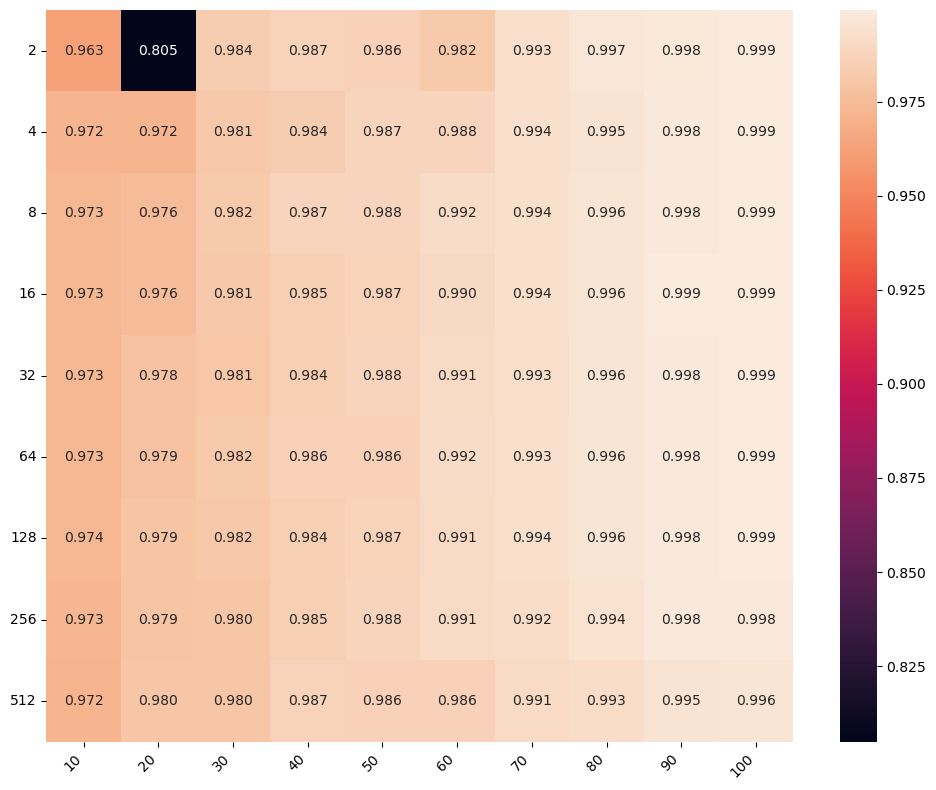

0.8049345098289247
0.9994129062237934 0.9994129062237934


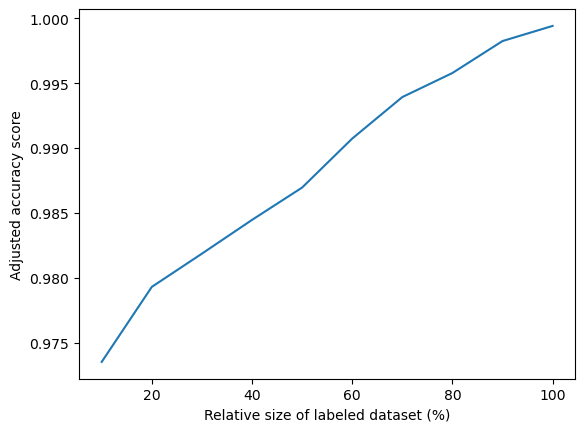

In [71]:
# Axis labels
y_labels = 2 ** np.arange(1, 10)
x_labels = range(10, 101, 10)

# Heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(scores, annot=True, fmt=".3f", cbar=True,
                 xticklabels=x_labels, yticklabels=y_labels)

ax.set_xticklabels(x_labels, rotation=45, ha="right")  
ax.set_yticklabels(y_labels, rotation=0)             

plt.tight_layout()
plt.show()

print(scores[0,1]) # outlier!
print(scores[0,-1], scores[3,-1]) # best


plt.plot(x_labels, scores[6,:])
plt.xlabel(r"Relative size of labeled dataset (%)")
plt.ylabel("Adjusted accuracy score")
plt.show()

Most models with enough labled data are very good, and we get exactly the same results 0.9994129062237934, which is basically perfect (1 misclassification).

In [107]:
data10p  = kmeans_obj[6,0]
data20p  = kmeans_obj[-1,1]
bad = kmeans_obj[0,1]
data50p  = kmeans_obj[2,4]
data90p  = kmeans_obj[3,-2]
data100p = kmeans_obj[0,-1]

# sample tests - not for report
print("10% dim=128:\n", confusion_matrix(y_train, data10p))
# print("20% dim=512:\n", confusion_matrix(y_train, data20p))
print("Worst: 20% dim=2:\n", confusion_matrix(y_train, bad))
# print("50% dim=8:\n", confusion_matrix(y_train, data50p))
print("90% dim=256:\n", confusion_matrix(y_train, data90p))
# print("100% dim=2:\n", confusion_matrix(y_train, data100p))

10% dim=128:
 [[   0    0    1    0  652]
 [   1    0   21 1052    6]
 [ 867    0    0    0    0]
 [   1    1 1047    5    7]
 [   2 1067    2    2    0]]
Worst: 20% dim=2:
 [[   0  653    0    0    0]
 [   0   16   34    0 1030]
 [ 867    0    0    0    0]
 [   1 1047   10    1    2]
 [   1    0    1 1069    2]]
90% dim=256:
 [[   0    0    0    0  653]
 [   0    1 1079    0    0]
 [ 867    0    0    0    0]
 [   0 1061    0    0    0]
 [   0    0    1 1072    0]]


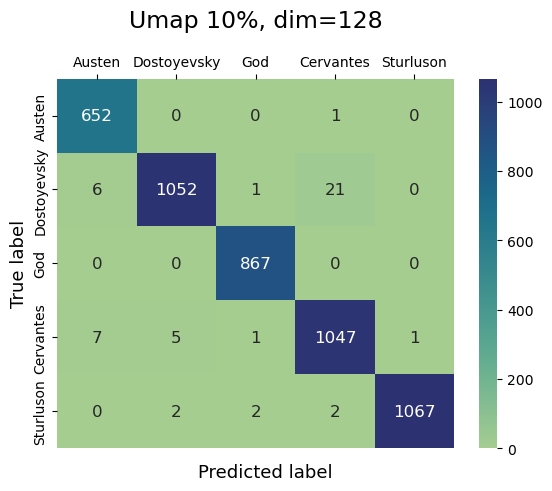

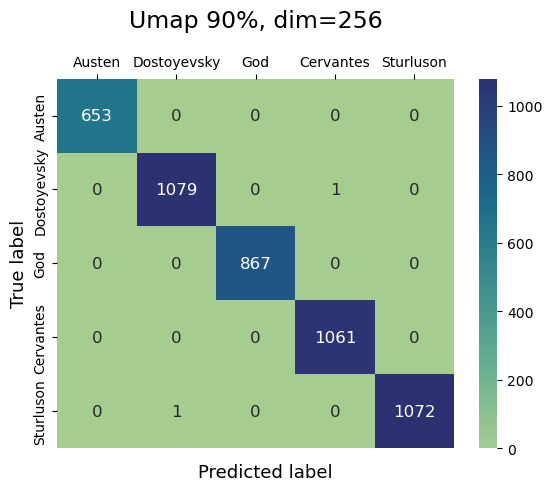

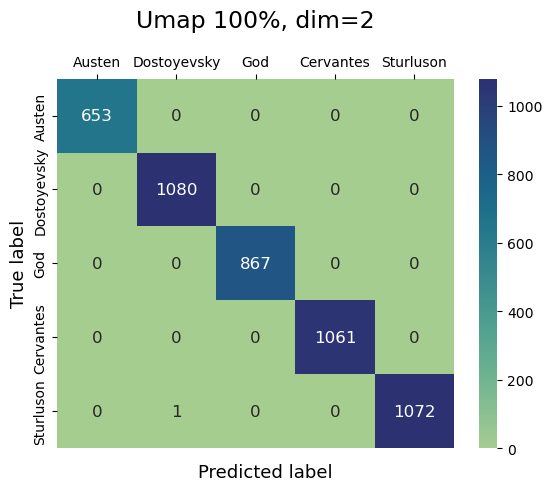

In [105]:
def sort_matrix(matrix):
    """Reorders the design matrix for ease of reading - note that no information is added"""
    return matrix[:,np.argmax(matrix, axis=1)]

def plot_confusion_matrix(cm, title):
    ax = sns.heatmap(cm, 
            annot=True,
            annot_kws={"fontsize":12},
            fmt=".0f",
            xticklabels=['Austen', 'Dostoyevsky', 'God', 'Cervantes', 'Sturluson'],
            yticklabels=['Austen', 'Dostoyevsky', 'God', 'Cervantes', 'Sturluson'],
            cmap='crest')
    plt.ylabel('True label', fontsize=13)
    plt.title(title, fontsize=17, pad=20, loc='center')
    ax.set(xlabel="", ylabel="True label")
    ax.xaxis.tick_top()

    plt.gca().figure.text(0.45, 0.05, 'Predicted label', ha='center', fontsize=13)
    plt.show()

# 10%, dim 128
plot_confusion_matrix(sort_matrix(confusion_matrix(y_train, data10p)), 'Umap 10%, dim=128')
# 90% dim=256
plot_confusion_matrix(sort_matrix(confusion_matrix(y_train, data90p)), 'Umap 90%, dim=256')
# 100% dim=2
plot_confusion_matrix(sort_matrix(confusion_matrix(y_train, data100p)), 'Umap 100%, dim=2')
